# Load and Preprocess the scRNA-seq Data

Show available datasets from the `pertdata` package:

In [1]:
import pertdata as pt

datasets_dict = pt.datasets()
print("Available datasets:")
for key in datasets_dict.keys():
    print(f"  {key}")

Available datasets:
  DixitRegev2016
  NormanWeissman2019_filtered
  ReplogleWeissman2022_K562_essential
  ReplogleWeissman2022_rpe1
  adamson
  dixit
  norman
  replogle_k562_essential
  replogle_rpe1_essential
  wessel_dataset


Load the "NormanWeissman2019_filtered" dataset:

In [2]:
import os

NormanWeissman2019_filtered = pt.PertDataset(
    name="NormanWeissman2019_filtered",
    cache_dir_path=os.path.join("..", "cache", "pertdata"),
)
print(NormanWeissman2019_filtered)
adata = NormanWeissman2019_filtered.adata

Dataset already cached: /workspaces/transmet/cache/pertdata/NormanWeissman2019_filtered
Loading: /workspaces/transmet/cache/pertdata/NormanWeissman2019_filtered/adata.h5ad
PertDataset object
    name: NormanWeissman2019_filtered
    cache_dir_path: /workspaces/transmet/cache/pertdata
    path: /workspaces/transmet/cache/pertdata/NormanWeissman2019_filtered
    adata: AnnData object with n_obs ✕ n_vars = 111445 ✕ 33694


- The expression matrix is in `adata.X` with cells as rows and genes as columns.
- Perturbation labels are stored in `adata.obs["perturbation"]`.
- Gene names are in `adata.var_names`.

In [3]:
perturbations = adata.obs["perturbation"].unique()
genes = adata.var_names
print(f"Unique perturbations: {len(perturbations)}")
print(f"Unique genes: {len(genes)}")

Unique perturbations: 237
Unique genes: 33694


Demultiplex `adata` for control/single/double perturbations.

In [4]:
adata_control = adata[adata.obs["nperts"] == 0].copy()
adata_single = adata[adata.obs["nperts"] == 1].copy()
adata_double = adata[adata.obs["nperts"] == 2].copy()

In [5]:
perturbations_control = adata_control.obs["perturbation"].unique()
perturbations_single = adata_single.obs["perturbation"].unique()
perturbations_double = adata_double.obs["perturbation"].unique()

print(f"Unique control perturbations: {len(perturbations_control)}")
print(f"Unique single perturbations: {len(perturbations_single)}")
print(f"Unique double perturbations: {len(perturbations_double)}")

Unique control perturbations: 1
Unique single perturbations: 105
Unique double perturbations: 131


We will continue working **with single-gene perturbations only**.
Also, we remove perturbations that are not measured.

In [6]:
to_remove = []
for perturbation in perturbations_single:
    if perturbation not in adata_single.var_names:
        to_remove.append(perturbation)

print(f"Removing {len(to_remove)} perturbations: {to_remove}")

adata_single_filtered = adata_single[
    ~adata_single.obs["perturbation"].isin(to_remove)
].copy()

perturbations_single_filtered = adata_single_filtered.obs["perturbation"].unique()
print(f"Unique single filtered perturbations: {len(perturbations_single_filtered)}")

Removing 3 perturbations: ['C3orf72', 'C19orf26', 'KIAA1804']
Unique single filtered perturbations: 102


Ensure that the expression matrix is in a dense format:

In [7]:
from scipy.sparse import issparse

if issparse(adata_single_filtered):
    adata_single_filtered.X = adata_single_filtered.X.toarray()

Aggregate (pseudobulk) the single-cell data per perturbation:

In [8]:
Y_train = []

for perturbation in perturbations_single_filtered:
    # Subset the data for the current perturbation.
    cells = adata_single_filtered[
        adata_single_filtered.obs["perturbation"] == perturbation
    ]

    # Compute the average expressions across cells.
    mean_expressions = cells.X.mean(axis=0)

    # Append the mean expression to Y_train.
    Y_train.append(mean_expressions)

Convert `Y_train` to a numpy array:

In [9]:
import numpy as np

Y_train = np.array(Y_train).squeeze()

# The Linear Gene Expression Model

In the Linear Gene Expression Model (LGEM) by [Ahlmann-Eltze et al. (2024)](https://doi.org/10.1101/2024.09.16.613342), we have:
- Embeddings for read-out genes: $G$ (an $n \times K$ matrix, where $n$ is the number of read-out genes and $K$ is the dimensionality of the embeddings).
- Embeddings for perturbations: $P$ (an $m \times K$ matrix, where $m$ is the number of perturbations).

Given a data matrix $Y_{\text{train}}$ of gene expression values, the model then fits the matrix $W$ by minimizing:
$$
\arg\min_{W} \| Y_{\text{train}} - (G W P^\top + b) \|^2
$$

Hence, we furthermore have:
- Data matrix: $Y_{\text{train}}$ (an $n \times m$ matrix, i.e., pseudobulked per condition/perturbation).
- Weight matrix: $W$ (a $K \times K$ matrix to be learned).
- Bias vector: $b$ (an $n \times 1$ vector of average gene expressions).

The model then predicts gene expression values using:
$$
Y_{\text{train}} \approx G W P^\top + b
$$

Note: The bias vector $b$ (with dimensions $n \times 1$) is added to each column of the matrix $G W P^\top$ (with dimensions $n \times m$).
This operation effectively _broadcasts_ the vector $b$ across all $m$ columns, repeating it $m$ times to match the dimensions of $G W P^\top$.
PyTorch handles broadcasting automatically implicitly.

In the paper, to obtain the embeddings $G$ and $P$, they performed a PCA on $Y_{\text{train}}$ and used the top $K$ principal components for $G$.
They then subset this $G$ to only the rows corresponding to genes that have been perturbed in the training data (and hence appear as columns in $Y_{\text{train}}$) and used the resulting matrix for $P$.
When using the model for prediction, they replace $P$ with the matrix formed by the rows of $G$ corresponding to genes perturbed in the test data.

Prepare the expression matrix $Y_{\text{train}}$:

In [10]:
Y_train_copy = Y_train.copy()
Y_train = Y_train.T  # Shape: (n_genes, n_perturbations)

Perform a PCA on $Y_{\text{train}}$ to obtain the top $K$ principal components, which will serve as the gene embeddings $G$:

In [11]:
from sklearn.decomposition import PCA

K = 10
pca = PCA(n_components=K)
G = pca.fit_transform(Y_train)  # Shape: (n_genes, K)

Extract perturbation embeddings $P$ from $G$ by subsetting $G$ to only the rows corresponding to genes that have been perturbed in the training data:

In [12]:
# Identify the indexes of perturbations.
indexes = [
    list(adata_single_filtered.var_names).index(gene_name)
    for gene_name in perturbations_single_filtered
]

# Extract P from G.
P = G[indexes, :]  # Shape: (n_perturbations, K)

Compute $b$ as the average expression of each gene across all perturbations:

In [13]:
b = Y_train.mean(axis=1, keepdims=True)  # Shape: (n_genes, 1)

Center $Y_{\text{train}}$ by subtracting $b$:

In [14]:
Y_centered = Y_train - b  # Shape: (n_genes, n_perturbations)

We can vectorize the equation $Y_{\text{centered}} = G W P^\top$ and set it up in a form suitable for least squares.

Using the mixed-product property of the Kronecker product, we have:
$$
\text{vec} (Y_{\text{centered}}) = (P \otimes G) \text{vec} (W)
$$

Here:
- $\text{vec} (Y_{\text{centered}})$ is the vectorization of $Y_{\text{centered}}$ (flattened column-wise).
- $P \otimes G$ is the Kronecker product of $P$ and $G$.
- $\text{vec} (W)$ is the vectorization of $W$ (flattened column-wise).

In [15]:
from scipy.linalg import kron

# Flatten Y_centered.
Y_vec = Y_centered.flatten(order="F")

# Ensure that P and G are numpy arrays.
P = np.array(P)
G = np.array(G)

# Compute the Kronecker product of P and G.
Kron_P_G = kron(P, G)  # Shape: (n_genes * n_perturbations, K * K)

We can now solve the linear equation:
$$
Y_{\text{vec}} = (P \otimes G) \cdot W_{\text{vec}}
$$

In [16]:
from numpy.linalg import lstsq

# Solve the least squares problem.
W_vec, residuals, rank, s = lstsq(Kron_P_G, Y_vec, rcond=None)

# Reshape vec(W) back to matrix W.
W = W_vec.reshape(K, K, order="F")

Verify:

In [17]:
# Reconstruct Y_centered using G, W, and P.
Y_centered_pred = G @ W @ P.T  # Shape: (n_genes, n_perturbations)

# Compute the mean squared error.
mse = np.mean((Y_centered - Y_centered_pred) ** 2)
print(f"MSE: {mse}")

MSE: 0.4264335036277771


# Formulating the Linear Gene Expression Model As a Neural Network

The LGEM formulation matches the standard linear layer in neural networks, where the output is a linear transformation of the input plus a bias term.
By combining $G$ and $W$ into a single matrix $M = G W$ with dimensions $n \times K$, we can write the prediction for each perturbation as:
$$
y = M p^\top + b
$$

Here:
- $y$ is the predicted gene expression vector ($n \times 1$).
- $p^\top$ is the transpose of the perturbation embedding vector ($K \times 1$).
- $M$ serves as the weight matrix in the neural network.
- $b$ is the bias vector.

This can directly be interpreted as the standard linear layer given by:
$$
y = W x + b
$$

Note that both models are linear.
We can now choose to keep $G$ fixed (i.e., it consists of the top $K$ principal components from a PCA on $Y_{\text{train}}$), and only learn $W$.
Then, the neural network (_without activation functions_) is equivalent to the original LGEM.
$M = G W$ would then be a combination of the fixed $G$ and the learned $W$.

Options for improvement:
- We can choose to set $G$ to be learnable.
- We can include non-linearity (i.e., activation functions) in the model.

In [18]:
# Ensure that G, P, b, and Y_train are numpy arrays.
G_np = np.array(G)  # Shape: (n_genes, K)
P_np = np.array(P)  # Shape: (n_perturbations, K)
b_np = np.array(b)  # Shape: (n_genes, 1)
Y_train_np = np.array(Y_train)  # Shape: (n_genes, n_perturbations)

In [19]:
import torch

# Convert numpy arrays to torch tensors.
# Note: By default tensors created from numpy arrays have requires_grad=False, which is
# what we want for fixed G, P, and b.
G_tensor = torch.from_numpy(G_np).float()
P_tensor = torch.from_numpy(P_np).float()
b_tensor = torch.from_numpy(b_np).float()
Y_train_tensor = torch.from_numpy(Y_train_np).float()

We create a custom PyTorch `nn.Module` where `W` is the only learnable parameter:

In [20]:
import torch.nn as nn


class LinearGeneExpressionModel(nn.Module):  # noqa: D101
    def __init__(self, G, b):  # noqa: D107, N803
        super(LinearGeneExpressionModel, self).__init__()
        self.G = G
        self.b = b
        K = G.shape[1]  # noqa: N806
        self.W = nn.Parameter(data=torch.randn(K, K))

    def forward(self, P):  # noqa: D102, N803
        M = self.G @ self.W  # noqa: N806
        Y_pred = M @ P.T  # noqa: N806
        Y_pred = Y_pred + self.b  # noqa: N806
        return Y_pred

Set up everything for training:

In [21]:
torch.manual_seed(seed=42)
model = LinearGeneExpressionModel(G=G_tensor, b=b_tensor)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=1e-3)

Note: Only model parameters that have `requires_grad=True` will be updated.

In [22]:
for name, param in model.named_parameters():
    if param.requires_grad:
        print(f"Parameter '{name}' will be updated during training.")

Parameter 'W' will be updated during training.


In [23]:
from torch.utils.data import DataLoader, TensorDataset

# Create a dataset and dataloader.
dataset = TensorDataset(P_tensor, Y_train_tensor.T)  # Transpose Y_train to match P.
batch_size = P_tensor.shape[0]  # Use the full dataset.
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [24]:
train_losses = []
num_epochs = 20000

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0

    for batch_P, batch_Y in dataloader:  # noqa: N816
        optimizer.zero_grad()
        Y_pred = model(batch_P)
        loss = criterion(Y_pred, batch_Y.T)  # Transpose back to (n_genes x batch_size).
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    avg_epoch_loss = epoch_loss / len(dataloader)
    train_losses.append(avg_epoch_loss)

    if (epoch + 1) % 100 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_epoch_loss:.4f}")

Epoch [100/20000], Loss: 2730787.5000
Epoch [200/20000], Loss: 2173780.5000
Epoch [300/20000], Loss: 1843706.7500
Epoch [400/20000], Loss: 1622741.0000
Epoch [500/20000], Loss: 1451387.0000
Epoch [600/20000], Loss: 1303016.5000
Epoch [700/20000], Loss: 1167628.1250
Epoch [800/20000], Loss: 1042005.3750
Epoch [900/20000], Loss: 925242.4375
Epoch [1000/20000], Loss: 817101.1250
Epoch [1100/20000], Loss: 717489.6250
Epoch [1200/20000], Loss: 626303.7500
Epoch [1300/20000], Loss: 543382.6250
Epoch [1400/20000], Loss: 468498.9062
Epoch [1500/20000], Loss: 401361.7812
Epoch [1600/20000], Loss: 341620.5625
Epoch [1700/20000], Loss: 288876.2812
Epoch [1800/20000], Loss: 242690.8750
Epoch [1900/20000], Loss: 202596.1094
Epoch [2000/20000], Loss: 168103.8438
Epoch [2100/20000], Loss: 138714.1250
Epoch [2200/20000], Loss: 113924.0234
Epoch [2300/20000], Loss: 93236.0469
Epoch [2400/20000], Loss: 76165.3828
Epoch [2500/20000], Loss: 62246.4141
Epoch [2600/20000], Loss: 51038.9297
Epoch [2700/20000

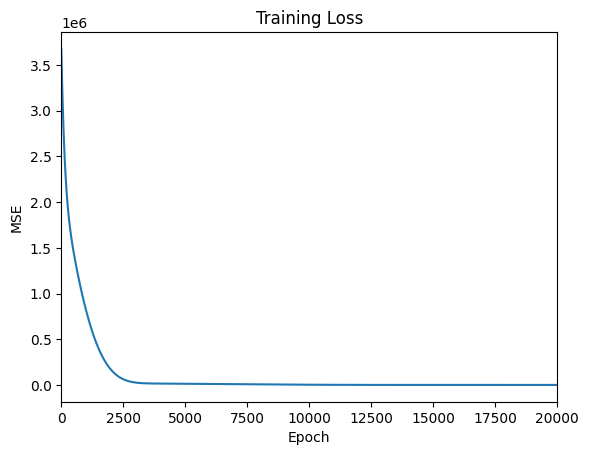

In [25]:
import matplotlib.pyplot as plt

plt.plot(train_losses)
plt.xlim(0, num_epochs)
plt.xlabel("Epoch")
plt.ylabel("MSE")
plt.title("Training Loss")
plt.show()

In [26]:
# Compute the mean squared error between the W obtained via least squares optimization
# and via learning.
mse = np.mean((W - model.W.detach().numpy()) ** 2)
print(f"MSE: {mse}")

MSE: 1.4702258340548724e-05
